In [1]:
import numpy as np
from matplotlib import pyplot as plt, style
from ipywidgets import interact

import chugunov_indicator as chug

import pynucastro as pyna
import yt

In [2]:
style.use("default")

In [3]:
def clip(x: np.ndarray, maximum: float = 1.01) -> np.ndarray:
    return np.where(x > maximum, maximum, x)

In [4]:
# Double Detonation data: http://groot.astro.sunysb.edu/common/
ds = yt.load('./data/subch_plt08582/')
ad = ds.all_data()

yt : [INFO     ] 2024-11-26 00:00:53,810 Parameters: current_time              = 0.40003216130915
yt : [INFO     ] 2024-11-26 00:00:53,811 Parameters: domain_dimensions         = [ 640 1280    1]
yt : [INFO     ] 2024-11-26 00:00:53,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-11-26 00:00:53,813 Parameters: domain_right_edge         = [5.12000000e+09 1.02400000e+10 6.28318531e+00]


In [5]:
density = np.array(ad["density"])
temperature = np.array(ad["Temp"])

The question posed is as follows: when can the calculation for the screening factor be skipped? For our purposes, we let the screening function $F$ be `pynucastro`'s implementation of `chugunov_2009`, and we consider the screening factor calculation to be skippable when it is less than $1.01$.

The screening function takes the form
$$
    F = F(T, \rho; \bar{A}, \bar{Z}, \overline{Z^2}; Z_1, A_1, Z_2, A_2),
$$
where the first two variables are properties of the plasma state, the next three are properties of the composition within that state, and the latter four are properties of the screening pair in question.

For a sample of double detonation data, the possible values of the four screening pair variables can be found via `pynucastro`'s `get_screening_map` function:

In [6]:
reaclib_library = pyna.ReacLibLibrary()

nuclei = [field[2:-1] for field in np.array(ds.field_list)[:,1] if "X(" in field]
comp = pyna.Composition(nuclei)

mynet = reaclib_library.linking_nuclei(comp.keys())
pynet = pyna.PythonNetwork(libraries=[mynet])

screen_map = pyna.screening.get_screening_map(
    pynet.get_rates(),
    symmetric_screening=pynet.symmetric_screening
)
display(*[
    {
        "z1": pair.n1.Z,
        "a1": pair.n1.A,
        "z2": pair.n2.Z,
        "a2": pair.n2.A
    }
    for pair in screen_map
])

{'z1': 1, 'a1': 1, 'z2': 6, 'a2': 12}

{'z1': 2, 'a1': 4, 'z2': 6, 'a2': 12}

{'z1': 2, 'a1': 4, 'z2': 7, 'a2': 14}

{'z1': 2, 'a1': 4, 'z2': 8, 'a2': 16}

{'z1': 2, 'a1': 4, 'z2': 9, 'a2': 18}

{'z1': 2, 'a1': 4, 'z2': 10, 'a2': 20}

{'z1': 1, 'a1': 1, 'z2': 10, 'a2': 21}

{'z1': 1, 'a1': 1, 'z2': 11, 'a2': 23}

{'z1': 2, 'a1': 4, 'z2': 11, 'a2': 23}

{'z1': 2, 'a1': 4, 'z2': 12, 'a2': 24}

{'z1': 1, 'a1': 1, 'z2': 13, 'a2': 27}

{'z1': 2, 'a1': 4, 'z2': 13, 'a2': 27}

{'z1': 2, 'a1': 4, 'z2': 14, 'a2': 28}

{'z1': 1, 'a1': 1, 'z2': 15, 'a2': 31}

{'z1': 2, 'a1': 4, 'z2': 16, 'a2': 32}

{'z1': 2, 'a1': 4, 'z2': 18, 'a2': 36}

{'z1': 2, 'a1': 4, 'z2': 20, 'a2': 40}

{'z1': 2, 'a1': 4, 'z2': 22, 'a2': 44}

{'z1': 2, 'a1': 4, 'z2': 24, 'a2': 48}

{'z1': 2, 'a1': 4, 'z2': 26, 'a2': 52}

{'z1': 6, 'a1': 12, 'z2': 6, 'a2': 12}

{'z1': 2, 'a1': 4, 'z2': 7, 'a2': 13}

{'z1': 1, 'a1': 1, 'z2': 8, 'a2': 16}

{'z1': 6, 'a1': 12, 'z2': 8, 'a2': 16}

{'z1': 8, 'a1': 16, 'z2': 8, 'a2': 16}

{'z1': 6, 'a1': 12, 'z2': 10, 'a2': 20}

{'z1': 2, 'a1': 4, 'z2': 2, 'a2': 4}

{'z1': 2, 'a1': 4, 'z2': 4, 'a2': 8}

Meanwhile, the composition variables can take on a whole spectrum of values. For the double detonation data, the global extrema are as follows:

In [7]:
Xs = np.array([ad[f"X({nucleus})"] for nucleus in nuclei]).T
As = np.array(list(comp.A.values()))
Zs = np.array(list(comp.Z.values()))
Ys = Xs / As

abar = 1 / np.sum(Ys, axis=1)
zbar = np.sum(Zs * Ys, axis=1) * abar
z2bar = np.sum(Zs**2 * Ys, axis=1) * abar

display(
    ("abar: ", abar.min(), abar.max()),
    ("zbar: ", zbar.min(), zbar.max()),
    ("z2bar: ", z2bar.min(), z2bar.max())
)

('abar: ', 4.028776676342192, 52.43965444432472)

('zbar: ', 2.0143883383557393, 26.223830930940498)

('z2bar: ', 4.1294958073363555, 713.3104742534674)

Lastly, the temperatures and densities of the detonation data appear in the following region:

In [8]:
display(
    ("log T: ", np.log10(temperature.min()), np.log10(temperature.max())),
    ("log D: ", np.log10(density.min()), np.log10(density.max())),
)

('log T: ', 6.98162931896528, 9.340288437793431)

('log D: ', -3.999999999613353, 7.995850585269622)

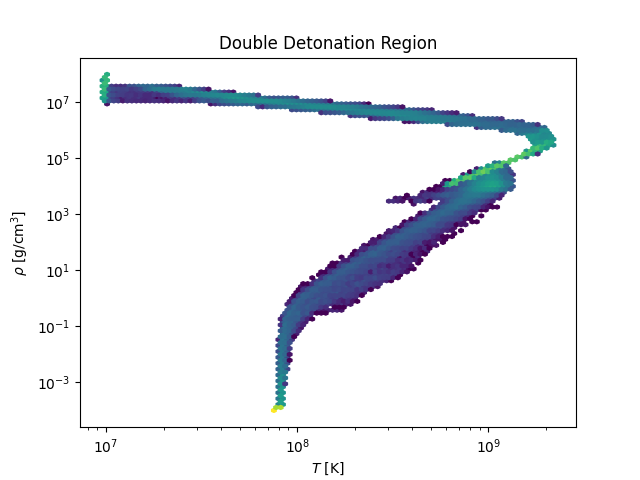

In [46]:
fig0, ax0 = plt.subplots()

chug.D_T_setup(ax0)

ax0.set_title("Double Detonation Region")

#detonation_data = ax0.scatter(temperature, density, s=1)
#detonation_data = ax0.hist2d(temperature, density, bins=[np.logspace(6.98, 9.34), np.logspace(-4, 8)], norm="log")
detonation_data = ax0.hexbin(temperature, density, bins="log", xscale="log", yscale="log")

For example, suppose we choose the following variables:

In [10]:
test_kwargs = {
    'abar': 4.028776983649795,
    'zbar': 2.0143884920095214,
    'z2bar': 4.12949645671095,
    'z1': 2,
    'a1': 4,
    'z2': 6,
    'a2': 12
}

With these held constant, the screening factor takes the following form on a grid:

In [11]:
D_, T_ = np.logspace(-4, 8, num=100), np.logspace(7, 9.35, num=100)
T, D = np.meshgrid(T_, D_)

In [12]:
F = chug.chugunov_2009(T=T, D=D, **test_kwargs)

Text(0.5, 1.0, 'min(F, 1.01)')

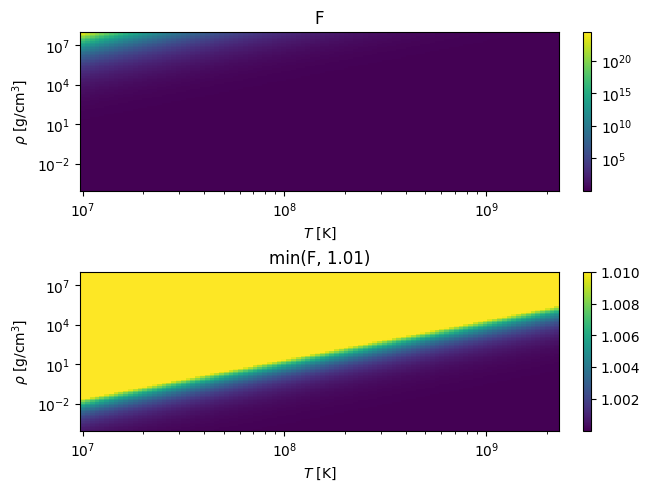

In [13]:
fig1, ax1 = plt.subplots(2, 1, constrained_layout=True)

chug.D_T_colorgraph(T, D, F, fig1, ax1[0], "log")

ax1[0].set_title("F")

chug.D_T_colorgraph(T, D, clip(F), fig1, ax1[1])

ax1[1].set_title("min(F, 1.01)")

#fig1.show()

Notice that in the second plot, the data is divided into two regions. The one above is where $F \geq 1.01$ (i.e. screening is important), while the one below is where $F < 1.01$ (i.e. screening can be skipped).

More importantly, notice that the two regions are divided by a line in log-log space. I claim that this relation holds in general - that is, the region where screening can be skipped is given by
$$
    \rho(T) \leq 10^{-c} T^k \iff \log_{10} \rho \leq k \log_{10} T - c,
$$
where equality represents the **border curve/line** that separates the two regions. Here, $-c$ is the $y$-intercept of the line and $k$ is its slope.

interactive(children=(FloatSlider(value=26.71982722216236, description='abar', max=52.43965444432472, min=1.0)…

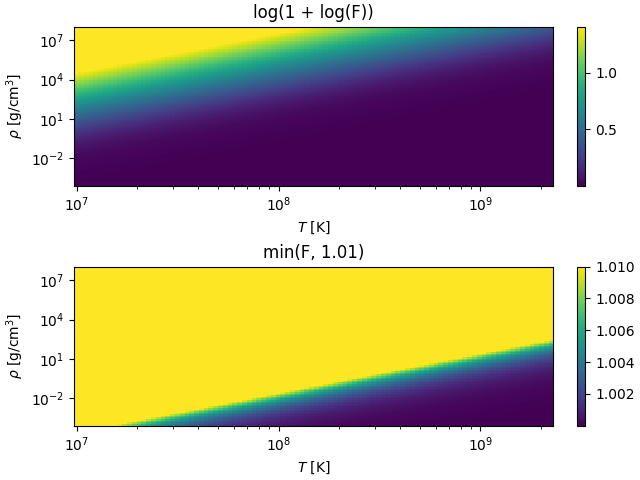

In [14]:
%matplotlib widget
fig2, ax2 = plt.subplots(2, 1, constrained_layout=True)

chug.D_T_setup(ax2)

ax2[0].set_title("log(1 + log(F))")
ax2[1].set_title("min(F, 1.01)")

params = {
    "abar": (1., 52.43965444432472),
    "zbar": (1., 200.),
    "z2bar": (1., 713.3104742534674),
    "z1": (1, 20),
    "z2": (1, 20),
    "a1": (1, 100),
    "a2": (1, 100) 
}

# Create initial plots
cb, cbar = chug.D_T_colorgraph(T, D, np.log10(1 + np.log10(F)), fig2, ax2[0])
cb2, cbar2 = chug.D_T_colorgraph(T, D, clip(F), fig2, ax2[1])

# Create sliders
@interact(**params)
def update(**kwargs) -> None:
    F = chug.chugunov_2009(T, D, **kwargs)
    cb.set_array(np.log10(1 + np.log10(F)))
    cb2.set_array(clip(F))
    cb.changed()
    cb2.changed()

# Show graph
#fig2.show()

In [15]:
fig2.savefig("chugunov_2009.svg")